# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score, roc_curve,auc
from imblearn.over_sampling import RandomOverSampler
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importing Dataset

In [ ]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# No Missing Values

In [ ]:
df.isna().any().any()

False

# Encoding Categorical Values

In [ ]:
#Columns with string values
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [ ]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)

In [ ]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Spliting into Train and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

# Hyper-parameter Tuning Using Grid Search CV

In [ ]:
def tune_hyperparameters(model,X,y):
  param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
  grid_search = GridSearchCV(model,param_grid=param_grid)
  grid_search.fit(X,y)
  print("Best Params: ",grid_search.best_params_)

### With Standardization

In [ ]:
tune_hyperparameters(LogisticRegression(max_iter=100000),X_train_standardized,y_train)

Best Params:  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


### With Normalization

In [ ]:
tune_hyperparameters(LogisticRegression(max_iter=100000),X_train_normalized,y_train)

Best Params:  {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}


# Performing Logistic Regression

In [ ]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("F1 Score: ",f1_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

  
  fpr,tpr,thresholds = roc_curve(y_test,y_pred)
  plt.plot(fpr, tpr,color='green',label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
  plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

### Without scaling

Accuracy:  0.7418918918918919
Precision:  0.7609254498714653
Recall:  0.751269035532995
F1 Score:  0.756066411238825
Confusion Matrix:
 [[253  93]
 [ 98 296]]


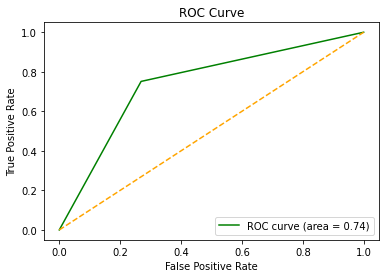

In [ ]:
train_predict_evaluate(LogisticRegression(max_iter=100000),X_train,y_train,X_test)

### With Standardization

Accuracy:  0.754054054054054
Precision:  0.7717948717948718
Recall:  0.7639593908629442
F1 Score:  0.7678571428571429
Confusion Matrix:
 [[257  89]
 [ 93 301]]


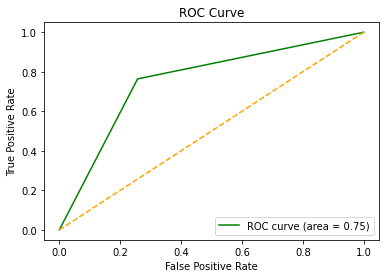

In [ ]:
train_predict_evaluate(LogisticRegression(max_iter=100000,C=0.1,penalty='l2',solver='newton-cg'),X_train_standardized,y_train,X_test_standardized)

### With Normalization

Accuracy:  0.7594594594594595
Precision:  0.7783505154639175
Recall:  0.766497461928934
F1 Score:  0.772378516624041
Confusion Matrix:
 [[260  86]
 [ 92 302]]


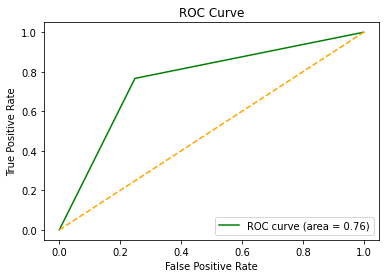

In [ ]:
train_predict_evaluate(LogisticRegression(max_iter=100000,C=1.0,penalty='l2',solver='saga'),X_train_normalized,y_train,X_test_normalized)

# K-Fold Cross Validation

In [ ]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  metrics = []
  metrics.append(np.mean(scores['test_accuracy']))
  metrics.append(np.mean(scores['test_precision']))
  metrics.append(np.mean(scores['test_recall']))
  metrics.append(np.mean(scores['test_f1']))

  print("Accuracy: ",metrics[0])
  print("Precision: ",metrics[1])
  print("Recall: ",metrics[2])
  print("F1 Score: ",metrics[3])

  return metrics

In [ ]:
metrics = []

### Without Scaling

In [ ]:
metrics.append(cross_validation(LogisticRegression(max_iter=100000),X,y))

Accuracy:  0.753443759187327
Precision:  0.7553370911853377
Recall:  0.7510253118725518
F1 Score:  0.7527202404649647


### With Standardization

In [ ]:
metrics.append(cross_validation(LogisticRegression(max_iter=100000,C=0.1,penalty='l2',solver='newton-cg'),X_standardized,y))

Accuracy:  0.769254584424863
Precision:  0.7585396295111104
Recall:  0.7915769724498866
F1 Score:  0.7742307533984836


### With Normalization

In [ ]:
metrics.append(cross_validation(LogisticRegression(max_iter=100000,C=1.0,penalty='l2',solver='saga'),X_normalized,y))

Accuracy:  0.7647953946341903
Precision:  0.7543334486556486
Recall:  0.7875316809848261
F1 Score:  0.7700579417845361


# Performance and Comparison Plots

In [ ]:
mdf = pd.DataFrame(metrics,columns=["Accuracy","Precision","Recall","F1 Score"],index=["Without Scaling","With Standardization","With Normalization"])
mdf.head()

,Accuracy,Precision,Recall,F1 Score
Without Scaling,0.753444,0.755337,0.751025,0.752720
With Standardization,0.769255,0.758540,0.791577,0.774231
With Normalization,0.764795,0.754333,0.787532,0.770058


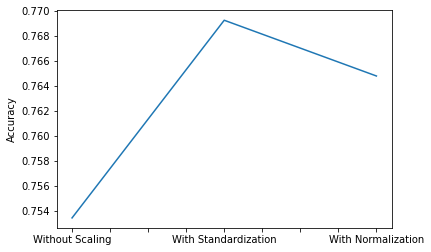

In [ ]:
mdf['Accuracy'].plot()
plt.ylabel("Accuracy")
plt.show()

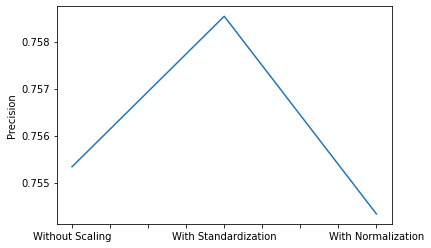

In [ ]:
mdf['Precision'].plot()
plt.ylabel("Precision")
plt.show()

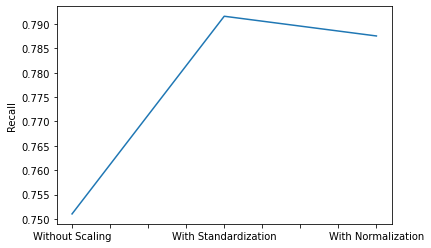

In [ ]:
mdf['Recall'].plot()
plt.ylabel("Recall")
plt.show()

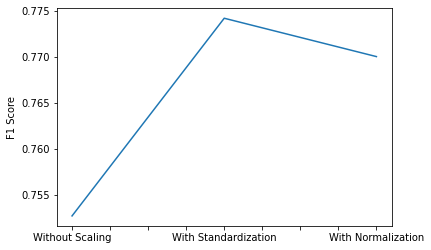

In [ ]:
mdf['F1 Score'].plot()
plt.ylabel("F1 Score")
plt.show()